Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB10

Use reinforcement learning to devise a tic-tac-toe player.

### Deadlines:

* Submission: Sunday, December 17 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Dies Natalis Solis Invicti ([CET](https://en.wikipedia.org/wiki/Sol_Invictus))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [1328]:
import numpy as np
from collections import namedtuple
from itertools import combinations
from enum import Enum, IntEnum 
import random

[4,9,2]
[3,5,7]
[8,1,6]

In [1329]:
Tikly = namedtuple("Tikly", "row, column")


class TikTakToe():

    class PlayerResult(IntEnum):
        X = 0
        O = 1
        Empty = -1
        Draw = 2

    def __init__(self, player = TikTakToe.PlayerResult.X):
        self.board = np.zeros(9)
        self.mask = np.array([4,9,2,3,5,7,8,1,6])
        # 1 for X, -1 for O
        if player == TikTakToe.PlayerResult.X:
            self.player = 1
        else:
            self.player = -1
        self.winner = TikTakToe.PlayerResult.Empty

    def move(self, position : Tikly) -> bool:
        position = position.row * 3 + position.column
        if self.board[position] == 0:
            self.board[position] = self.player * self.mask[position]
            self.player = -self.player
            return True
        else:
            return False

    def win (elements : list) -> bool:
        return any(sum(combination) == 15 for combination in combinations(elements, 3))

    def possible_moves(self) -> list:
        return [Tikly(i//3, i%3) for i in range(9) if self.board[i] == 0]

    def check_finished(self) -> bool:
        if np.sum(self.board == 0) == 0 or self.check_winner() != 0:
            return True
        else:
            return False 

    def check_winner(self) -> PlayerResult:
        player_1 = self.board[self.board > 0]
        player_2 = abs(self.board[self.board < 0])
        if TikTakToe.win(player_1):
            self.winner = TikTakToe.PlayerResult.X
        elif TikTakToe.win(player_2):
            self.winner = TikTakToe.PlayerResult.O
        elif np.sum(self.board == 0) == 0:
            self.winner = TikTakToe.PlayerResult.Draw
        else:
            self.winner = TikTakToe.PlayerResult.Empty

        return self.winner

    def print_winner(self) -> str:
        if self.winner == TikTakToe.PlayerResult.X:
            return("Player X")
        elif self.winner == TikTakToe.PlayerResult.O:
            return("Player O")
        elif self.winner == TikTakToe.PlayerResult.Draw:
            return("Draw")
        else:
            return("Game not finished")       

    def __str__(self):
        return f"Player to move : {self.player}"+ "\n" + str(self.board.reshape(3,3))
    
    def __repr__(self):
        return str(self.board)

In [1330]:
class Player():
    def __init__(self, k : int = None):
        self.k = k

    def play(self,board : np.array) -> Tikly :
        pass

    def update(self, result : bool):
        pass

    def __str__(self):
        return f"Player {self.__class__.__name__}"

In [1331]:
class RandomPlayer(Player):
    def __init__(self):
        super().__init__()

    def play(self, board : TikTakToe) -> Tikly:
        possible_moves = board.possible_moves()
        move = possible_moves[np.random.randint(len(possible_moves))]
        return move

In [1332]:
class HumanPlayer(Player):
    def __init__(self):
        super().__init__()

    def play(self, board : TikTakToe) -> Tikly:
        possible_moves = board.possible_moves()
        print("Possible moves : ", possible_moves)
        row = input("Row : ")
        column = input("Column : ")
        move = Tikly(row, column)
        return move

In [1333]:
class ReinforcedPlayer(Player) :
    def __init__(self, k : int = 0.1, epsilon : float = 0.1, alpha : float = 0.1, gamma : float = 0.9):
        super().__init__(k)
        self.epsilon = epsilon # exploration rate
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.Q = dict()
        self.state = None
        self.action = None
        self.sequence = []
        self.used_moves = 0
        self.wins = 0
        self.learning = True

    def play(self, game : TikTakToe) -> Tikly:
        if game.player == 1:
            self.state = tuple(game.board)
        else:
            self.state = tuple(-game.board)
        if self.state not in self.Q:
            self.Q[self.state] = {move: random.uniform(0, 1) for move in game.possible_moves()}
            self.action = max(self.Q[self.state], key= lambda k : self.Q[self.state][k])
        else:
            if random.uniform(0, 1) < self.epsilon:
                self.action = random.choice(list(self.Q[self.state].keys()))
            else:
                self.action = max(self.Q[self.state], key= lambda k : self.Q[self.state][k])
                self.used_moves += 1
        if self.learning:
            self.sequence.append((self.state, self.action))
        return self.action
    
    def update(self, reward : int) -> None: # reward is 1 if the player won, -1 if the player lost, 0.1 if draw
        for state, action in reversed(self.sequence):
            if self.sequence.__len__() == 3 and reward == 1:
                self.Q[state][action] = min(1 , self.Q[state][action] + self.alpha * (2 *reward * self.Q[state][action]))
            elif reward == 1:
                self.Q[state][action] = min(1 , self.Q[state][action] + self.alpha * (reward * self.Q[state][action]))
            else:
                self.Q[state][action] = max(0 , self.Q[state][action] + self.alpha * (2 * reward * self.Q[state][action]))
            reward = reward * self.gamma
        self.sequence = []

    def stop_learning(self):
        self.learning = False
        self.epsilon = 0


In [1334]:
class GameResults(Enum):
    Win = 1
    Loss = - 2
    Draw = - 0.5

### Training

Player X : Player RandomPlayer
Player O : Player ReinforcedPlayer


1330 already tried moves used with 1638 states with epsilon 0.4
Wins :  46.9 %
3153 already tried moves used with 2452 states with epsilon 0.38
Wins :  52.6 %
5302 already tried moves used with 2918 states with epsilon 0.361
Wins :  57.199999999999996 %
7574 already tried moves used with 3211 states with epsilon 0.34295
Wins :  57.9 %
9986 already tried moves used with 3400 states with epsilon 0.32580249999999994
Wins :  61.3 %
12493 already tried moves used with 3549 states with epsilon 0.30951237499999995
Wins :  64.2 %
15063 already tried moves used with 3654 states with epsilon 0.2940367562499999
Wins :  66.10000000000001 %
17677 already tried moves used with 3735 states with epsilon 0.2793349184374999
Wins :  70.1 %
20397 already tried moves used with 3808 states with epsilon 0.2653681725156249
Wins :  69.8 %
23164 already tried moves used with 3875 states with epsilon 0.2520997638898436
Wins :  70.19999999999999 %
26025 already tried moves used with 3919 states with epsilon 0.239

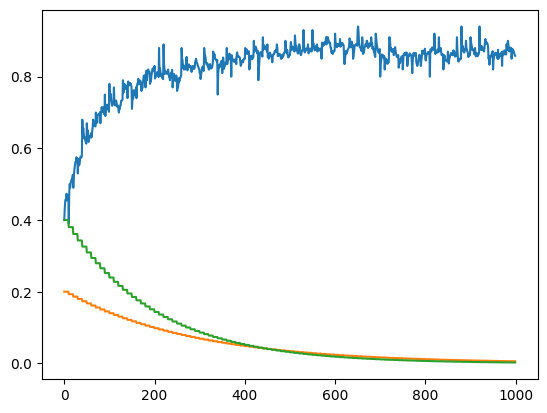

In [1335]:
import matplotlib.pyplot as plt
wins = [0,0,0]
started = [0,0]
perc = []
player = [RandomPlayer(), ReinforcedPlayer(epsilon=0.4, alpha=0.2, gamma=0.8)]
print(f"Player X : {player[0]}")
print(f"Player O : {player[1]}")
for rep in range(100_000):
    
    i = random.randint(0,1) # random player starts
    started[i] += 1
    game = TikTakToe(player=TikTakToe.PlayerResult(i))
    # play the game
    while game.check_winner() == TikTakToe.PlayerResult.Empty:
        game.move(player[i].play(game))
        i = 1 - i
    winner = game.check_winner()
    wins[int(winner)] += 1
    if winner != TikTakToe.PlayerResult.Draw:
        player[int(winner)].update(GameResults.Win.value)
        
        player[int(1-winner)].update(GameResults.Loss.value)
    else:
        player[0].update(GameResults.Draw.value)
        player[1].update(GameResults.Draw.value)
    
    if (rep + 1) % 1000  == 0:
        print(f"{player[1].used_moves} already tried moves used with {player[1].Q.__len__()} states with epsilon {player[1].epsilon}")
        print("Wins : ", wins[1] / (sum(wins)) * 100 , "%")
        perc.append((wins[1] / (sum(wins)) , player[1].alpha, player[1].epsilon ))
        player[1].epsilon *= 0.95
        player[1].alpha *= 0.965
        wins = [0,0,0]
    elif (rep + 1) % 100  == 0:
        perc.append((wins[1] / (sum(wins)) , player[1].alpha, player[1].epsilon ))
    
print("Wins : ", wins[1] / (rep) , "\nDraws : ", wins[2])
print("Started : ", started)
print(f"Q states : {player[1].Q}")

plt.plot(perc)
main_player = player[1]
main_player.stop_learning()

In [1336]:
board = TikTakToe()
print(board)
i = random.randint(0,1) # random player starts
while board.check_winner() == TikTakToe.PlayerResult.Empty:
    if i == 0:
        if tuple(board.board) in main_player.Q:
            #print(main_player.Q[tuple(board.board)])
            for key  in main_player.Q[tuple(board.board)]:
                print(key , " : ", main_player.Q[tuple(board.board)][key])
        else:
            print("Not in Q")
        board.move(main_player.play(board))
        print(board)
    else:
        board.move(RandomPlayer().play(board))
        print(board)
    i = 1 - i
print(board.print_winner())
    

Player to move : 1
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Tikly(row=0, column=0)  :  103.78022163810606
Tikly(row=0, column=1)  :  2.259912372975567e-05
Tikly(row=0, column=2)  :  116.2567488528811
Tikly(row=1, column=0)  :  0.21512212080288184
Tikly(row=1, column=1)  :  0
Tikly(row=1, column=2)  :  0.11157479674768109
Tikly(row=2, column=0)  :  6.668204221440713e+54
Tikly(row=2, column=1)  :  15.041152850363943
Tikly(row=2, column=2)  :  0
Player to move : -1
[[0. 0. 0.]
 [0. 0. 0.]
 [8. 0. 0.]]
Player to move : 1
[[-4.  0.  0.]
 [ 0.  0.  0.]
 [ 8.  0.  0.]]
Tikly(row=0, column=1)  :  7001460.135858883
Tikly(row=0, column=2)  :  0.73002191413966
Tikly(row=1, column=0)  :  0.42732584786753297
Tikly(row=1, column=1)  :  0.8201818429491913
Tikly(row=1, column=2)  :  0.031506083282971185
Tikly(row=2, column=1)  :  0.5506569244969292
Tikly(row=2, column=2)  :  0.44716229226161797
Player to move : -1
[[-4.  9.  0.]
 [ 0.  0.  0.]
 [ 8.  0.  0.]]
Player to move : 1
[[-4.  9.  0.]
 [ 0. -5.  0

In [1337]:
main_player.stop_learning()

wins = [0,0,0]
started = [0,0]
player = [main_player, RandomPlayer()]
print(f"Player X : {player[0]}")
print(f"Player O : {player[1]}")
for rep in range(1000):
    
    i = random.randint(0,1)
    started[i] += 1
    game = TikTakToe(player=TikTakToe.PlayerResult(i))
    # play the game
    #print("starts : ", player[i])
    while game.check_winner() == TikTakToe.PlayerResult.Empty:
        game.move(player[i].play(game))
        i = 1 - i
    winner = game.check_winner()
    #print(game)
    #print(game.print_winner())
    wins[int(winner)] += 1
    #print(game)
    #print(game.print_winner())
print("Wins : ", wins[:2] , "\nDraws : ", wins[2])

Player X : Player ReinforcedPlayer
Player O : Player RandomPlayer


Wins :  [872, 39] 
Draws :  89
